In [14]:
from uszipcode import SearchEngine
import networkx as nx
import pickle
import itertools
import random
from area import area
import math
from shapely.geometry import Polygon
import shapely.geometry as geometry
import folium as f
from scipy.spatial import ConvexHull


search = SearchEngine(simple_zipcode=False, db_file_dir="./zip_code_cache")

In [30]:
g = nx.read_gpickle("01_cambridge.gpickle")
nodes_data_subset = g.nodes().data()

## Populate dictionary of zip codes and node_ids.


### `zip_code_dict` and `nodes_by_zip` are inverses of each other

In [31]:
len_g = len(g)

def get_zip_code_dict(g):
    count = 1
    with open('zip_code_dict.pickle', 'rb') as handle:
        zip_code_dict = pickle.load(handle)

    for node_data in g.nodes().data():
        node_id = node_data[1]["id"]
        lon,lat = node_data[1]['lon'], node_data[1]['lat']
        if node_id not in zip_code_dict:
            count += 1
            zip_code_dict[node_id] = search.by_coordinates(lat, lon, returns=1)[0].zipcode
            print(str(len(zip_code_dict)) + "       "+ str(len(zip_code_dict)/len_g) + "        ...slow algo alert")


        if count % 100 == 0: 
            with open('zip_code_dict.pickle', 'wb') as handle:
                pickle.dump(zip_code_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)        

    with open('zip_code_dict.pickle', 'wb') as handle:
        pickle.dump(zip_code_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return zip_code_dict

# Generate reverse dictionary——nodes by zip instead of zips by node
def get_nodes_by_zip(zip_code_dict):
    nodes_by_zip = {}
    for node_id, zip_code in zip_code_dict.items():
        nodes_by_zip.setdefault(zip_code, []).append(node_id)
    return nodes_by_zip


zip_code_dict = get_zip_code_dict(g)
nodes_by_zip = get_nodes_by_zip(zip_code_dict)

In [79]:
def area_km2_from_g_nodes(g, zip_code):
    lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data() if x[0] in nodes_by_zip[zip_code]]
    if len(lat_lons) < 3:
        return .000000001
    hull = ConvexHull(lat_lons)
    hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]
    polygon = {'type': 'Polygon', 'coordinates': [hull_edges]}
    return (area(polygon) / 1000000)

def gen_population_dict(g):
    zips_in_g = {zip_code_dict[node_id] for node_id in g}
    population_dict = {}
    nodes_in_g = set(g)
    
    entire_pop = {z: search.by_zipcode(z).population for z in zips_in_g}
    pop_density = {z: search.by_zipcode(z).population_density for z in zips_in_g}
    land_area_in_km2 = {z: (search.by_zipcode(z).land_area_in_sqmi * 2.58999) for z in zips_in_g}
    nodes_in_zip = {z: list(set(nodes_by_zip[z]) & nodes_in_g) for z in zips_in_g}
    convex_hull_in_km2 = {z: area_km2_from_g_nodes(g, z) for z in zips_in_g}
    node_area_percent = {z: min([1, convex_hull_in_km2[z]/land_area_in_km2[z]]) for z in zips_in_g}
    est_pop_in_convex_hull = {z: area_km2_from_g_nodes(g, z) for z in zips_in_g}
    area_percentage = min([4, 1])
    
    
    
    return  {z: {
#                  "entire_pop": entire_pop[z],
#                  "pop_density": pop_density[z],
#                  "land_area_in_km2": land_area_in_km2[z],
#                  "land_area_from_nodes": convex_hull_in_km2[z],
                 "node_area_percent": node_area_percent[z],
#                  "nodes": nodes_in_zip[z]

                } 
              for z in zips_in_g}
    
    
pop_dict = gen_population_dict(g)

pop_dict

{'02140': {'node_area_percent': 3.3574076247062905e-10},
 '02199': {'node_area_percent': 0.32584511330113786},
 '02129': {'node_area_percent': 0.011644602163902729},
 '02135': {'node_area_percent': 1.468067972780317e-10},
 '02114': {'node_area_percent': 0.2735635608799142},
 '02141': {'node_area_percent': 1},
 '02134': {'node_area_percent': 0.27822140855329},
 '02108': {'node_area_percent': 0.008177387707952106},
 '02142': {'node_area_percent': 1},
 '02446': {'node_area_percent': 0.010472155116296544},
 '02143': {'node_area_percent': 0.5265648058449993},
 '02139': {'node_area_percent': 0.7908773651978571},
 '02163': {'node_area_percent': 1},
 '02138': {'node_area_percent': 0.06580787845823205},
 '02116': {'node_area_percent': 0.32129764300000047},
 '02145': {'node_area_percent': 2.7578705488658816e-10}}

In [154]:
ZIP_CODE = '02138'
m = f.Map(location = [42.3611108,-71.119977], zoom_start=14)


style = {
    "fillColor": "salmon",
    "fillOpacity": .2,
    "weight": 2,
    "opacity": 1
}

# Show graph with hull edges
for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    if node_id in nodes_by_zip[ZIP_CODE]:
        if not node_data[1].get('lon'):
            import pdb; pdb.set_trace()
        lon,lat = node_data[1]['lon'], node_data[1]['lat'] 
        if [lon, lat] in hull_edges:
            m.add_child(f.Marker(location=[lat,lon], color="red", radius=1))
        m.add_child(f.CircleMarker(location=[lat,lon], color="blue", radius=1))

        
polyg = Polygon(search.by_zipcode(ZIP_CODE).polygon)

f.GeoJson(polyg, style_function=lambda x: style).add_to(m)

m
# polyg.contains(Point(-71.0825, 42.3636))

## This is useful scratch. Use `area` library to find Polygon's geographic area

### First, simple PoC with Wyoming

In [80]:
wyoming = {'type':'Polygon','coordinates':[[[-111.046768, 40.997963], 
                                            [-111.055196, 45.001320], 
                                            [-104.057691, 44.997377],
                                            [-104.053251, 41.001410],
                                            [-111.046768, 40.997963]]]}

area_km2 = area(wyoming)

area_km2 = area_km2 / 1e+6
# print ('area m2: ' + str(math.floor(area_m2)))
print ('Estimated area of Wyoming: ' + str(math.floor(area_km2)) + 'km^2')
print("Error:                     " + str(253600 - math.floor(area_km2)) + "km^2" )

Estimated area of Wyoming: 253529km^2
Error:                     71km^2


### Now running on entire Cambridge dataset. (Note—outliers skew this)

In [81]:
from scipy.spatial import ConvexHull

lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
hull = ConvexHull(lat_lons)
hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]

camb = {'type': 'Polygon', 'coordinates': [hull_edges]}

print("Area of convex map: " + (str (area(camb) / 1000000)) + "km^2")



Area of convex map: 21.747622196450717km^2


In [83]:
m = f.Map(location = [42.3611108,-71.1079923], zoom_start=16)

# Show graph with hull edges
for node_data in g.nodes().data():
    node_id = node_data[1]["id"]
    if not node_data[1].get('lon'):
        import pdb; pdb.set_trace()
    lon,lat = node_data[1]['lon'], node_data[1]['lat']  
    if [lon, lat] in hull_edges:
        m.add_child(f.Marker(location=[lat,lon], color="red", radius=1))
    
    m.add_child(f.CircleMarker(location=[lat,lon], color="orange", radius=.5))
    
    

m

# *_CRUFT ZONE_* (mostly noodling trying to get area from nodes)

In [72]:
import pyproj    
import shapely
import shapely.ops as ops
from shapely.geometry.polygon import Polygon
from functools import partial


# geom = Polygon([[40.997963, -111.046768], 
#                 [45.001320, -111.055196], 
#                 [44.997377, -104.057691],
#                 [41.001410, -104.053251],
#                 [40.997963, -111.046768]])


geom = Polygon([[-111.046768, 40.997963], 
                [-111.055196, 45.001320], 
                [-104.057691, 44.997377],
                [-104.053251, 41.001410],
                [-111.046768, 40.997963]])
# geom = Polygon([[40,-111],
#                 [2,3],
#                 [3,5],
#                 [40,-111]])
geom_area = ops.transform(
    partial(
        pyproj.transform,
        pyproj.Proj(init='EPSG:4326'),
        pyproj.Proj(
            proj='aea',
            lat_1=geom.bounds[1],
            lat_2=geom.bounds[3])),
    geom)

# Print the area in m^2
print (math.floor(geom_area.area / 1000000) )

/Users/cromptonwork/opt/anaconda3/envs/bikepoints-scratch/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/cromptonwork/opt/anaconda3/envs/bikepoints-scratch/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


253115


In [100]:
ZIP_CODE = '02139'
search.by_zipcode(ZIP_CODE)

Zipcode(zipcode_type='Standard', major_city='Cambridge', post_office_city='Cambridge, MA', common_city_list=['Cambridge'], county='Middlesex County', state='MA', lat=42.36, lng=-71.1, timezone='Eastern', radius_in_miles=1.0, area_code_list=['339', '781', '978', '508', '617', '857'], population=36349, population_density=23355.0, land_area_in_sqmi=1.56, water_area_in_sqmi=0.14, housing_units=15402, occupied_housing_units=14519, median_home_value=488800, median_household_income=71745, bounds_west=-71.117193, bounds_east=-71.086975, bounds_north=42.376332, bounds_south=42.352397, zipcode='02139', polygon=[[-71.110182, 42.369982], [-71.1099, 42.370391], [-71.109736, 42.370627], [-71.109614, 42.370806], [-71.109156, 42.371517], [-71.109024, 42.371511], [-71.10887, 42.371462], [-71.108441, 42.371329], [-71.107947, 42.372056], [-71.108615, 42.372318], [-71.108517, 42.37246], [-71.108215, 42.372903], [-71.107784, 42.373502], [-71.107223, 42.374295], [-71.107061, 42.374526], [-71.106121, 42.3744

In [98]:
search.by_zipcode(ZIP_CODE).polygon

[[-71.110182, 42.369982],
 [-71.1099, 42.370391],
 [-71.109736, 42.370627],
 [-71.109614, 42.370806],
 [-71.109156, 42.371517],
 [-71.109024, 42.371511],
 [-71.10887, 42.371462],
 [-71.108441, 42.371329],
 [-71.107947, 42.372056],
 [-71.108615, 42.372318],
 [-71.108517, 42.37246],
 [-71.108215, 42.372903],
 [-71.107784, 42.373502],
 [-71.107223, 42.374295],
 [-71.107061, 42.374526],
 [-71.106121, 42.37441],
 [-71.105899, 42.374389],
 [-71.105679, 42.375361],
 [-71.105427, 42.376332],
 [-71.104996, 42.37595],
 [-71.104702, 42.375691],
 [-71.104173, 42.375201],
 [-71.103664, 42.374763],
 [-71.103172, 42.374297],
 [-71.10157, 42.374334],
 [-71.100361, 42.37436],
 [-71.099477, 42.374386],
 [-71.098937, 42.374398],
 [-71.097639, 42.374427],
 [-71.097463, 42.374431],
 [-71.097416, 42.374428],
 [-71.096337, 42.374369],
 [-71.09552, 42.374325],
 [-71.094749, 42.374292],
 [-71.094741, 42.374268],
 [-71.094533, 42.373637],
 [-71.094419, 42.373237],
 [-71.094488, 42.372913],
 [-71.095322, 42.3730

### `alphashape` is too expensive and requires too much noodling to be of use for us for this problem

In [74]:


# import alphashape

# points = [(17, 158),(15, 135),(38, 183),(43, 19),(93, 88),(96, 140),(149, 163),(128, 248),(216, 265),(248, 210),(223, 167),(256, 151),(331, 214),(340, 187),(316, 53),(298, 35),(182, 0),(121, 42)]
# lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
# points = lat_lons[:1000]
# alpha = 0.95 * alphashape.optimizealpha(points)
# hull = alphashape.alphashape(points, alpha)
# hull_pts = hull.exterior.coords.xy
# print(hull_pts)

# from scipy.spatial import ConvexHull

# lat_lons = [[x[1]["lat"], x[1]["lon"]] for x in g.nodes().data()]
# hull = ConvexHull(lat_lons)
# hull_edges = [[hull.points[ix][1], hull.points[ix][0]] for ix in hull.vertices]

# camb = {'type': 'Polygon', 'coordinates': [hull_edges]}

# print("Area of convex map: " + (str (area(camb) / 1000000)) + "km^2")



In [75]:




from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
from shapely.geometry import Point

import numpy as np
import geopandas

import math
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
    coords = np.array([point.coords[0]
                       for point in points])
    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the
    # triangle
    for ia, ib, ic in tri.vertices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]
        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
        # Semiperimeter of triangle
        s = (a + b + c)/2.0
        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)
        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

concave_hull, edge_points = alpha_shape(([Point(x[0], x[1]) for x in [[11,2], [12,2], [22,1], [12.5,1.5], [12,21]]]),
                                        alpha=.2)

In [76]:
concave_hull.area

0.25

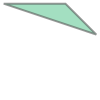

In [77]:
concave_hull

In [52]:
set(g)

{'1829996101',
 '314502420',
 '3990569508',
 '7579360368',
 '4696389653',
 '61332332',
 '5850994443',
 '1705743863',
 '7628787293',
 '7746087648',
 '61327635',
 '4599191133',
 '4333397061',
 '314502652',
 '7279261658',
 '3101702890',
 '7771246880',
 '7629493600',
 '4439514300',
 '61324503',
 '2292105334',
 '5737576890',
 '5562633678',
 '4333421651',
 '5458365624',
 '5458947272',
 '7725588125',
 '61324858',
 '61327172',
 '1705822880',
 '5244314184',
 '7628787438',
 '61326941',
 '6866895632',
 '7631668843',
 '7629198647',
 '1479740382',
 '7727679871',
 '5458857467',
 '61329266',
 '6771296964',
 '7560377031',
 '7802219115',
 '3809869817',
 '7628615146',
 '7631495281',
 '5843638171',
 '7514942848',
 '61283366',
 '4470898302',
 '314502262',
 '7629493951',
 '71921217',
 '688404514',
 '5493338399',
 '7629147643',
 '7693370598',
 '380880846',
 '7626171386',
 '3620929818',
 '1830019665',
 '7634162226',
 '7629494064',
 '2658346330',
 '6540279185',
 '7629147360',
 '7628856065',
 '7634557516',
 '3

In [78]:
def CRUFT_semi_random_nodes(g, percentage):
    k = percentage * len(g)
    zips_in_g = {zip_code_dict[node_id] for node_id in g}
    
    weight_by_zip = {}
    for zip_code in zips_in_g:
        weight_by_zip[zip_code] = area_km2_from_map(g, zip_code) * search.by_zipcode(zip_code).population_density
    
    sum_of_weights = sum([v for k,v in weight_by_zip.items()])    
    set_of_nodes_g = set({node for node in g})
    
    num_by_zip = {}
    for zip_code in zips_in_g:
        absolute_num = math.ceil(weight_by_zip[zip_code]*k/sum_of_weights)
        nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)
        if absolute_num > len(nodes_in_zip_code):
            print(zip_code)
            print("absolute num:    " + str(absolute_num))
            print("number of nodes: " + str(len(nodes_in_zip_code)))
            area_from_points = (area_km2_from_map(g, zip_code))
            land_area = (search.by_zipcode(zip_code).land_area_in_sqmi * 2.58999)
            print(area_from_points / land_area)
            print("____")
        else: print("***" + str(absolute_num))
        num_by_zip[zip_code] = absolute_num
#     print("[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]")
#     for zip_code in zips_in_g:
#         nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)

#         print(zip_code)
#         print("number of nodes: " + str(len(nodes_in_zip_code)))
        
    return_nodes = {}
    for zip_code,num in num_by_zip.items():
        nodes_in_zip_code = list(set(nodes_by_zip[zip_code]) & set_of_nodes_g)
        if len(nodes_in_zip_code) > num:
            return_nodes[zip_code] = random.sample(nodes_in_zip_code, num)
        else:    
            return_nodes[zip_code] = nodes_in_zip_code
    

          
    return list(itertools.chain.from_iterable([nodes for zip_code,nodes in return_nodes.items()]))
aa = semi_random_nodes(g, 1)
print(len(aa)/ len(g))
## ISSUE HERE: why does it go down down down when the k value goes up?

***1
02199
absolute num:    27
number of nodes: 5
0.32584511330113786
____
02129
absolute num:    13
number of nodes: 4
0.011644602163902729
____
***1
02114
absolute num:    223
number of nodes: 12
0.2735635608799142
____
***1183
02134
absolute num:    407
number of nodes: 247
0.27822140855329
____
***3
***407
02446
absolute num:    21
number of nodes: 5
0.010472155116296544
____
02143
absolute num:    877
number of nodes: 716
0.5265648058449993
____
02139
absolute num:    1955
number of nodes: 1483
0.7908773651978571
____
***1479
***163
02116
absolute num:    450
number of nodes: 237
0.32129764300000047
____
***1
0.8257428492085532


In [141]:
[42.359811, -71.073183]

[42.359811, -71.073183]

In [143]:
search.by_coordinates(42.359811, -71.073183, returns=1)[0].zipcode

'02142'